In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
torch.__version__

'2.5.1'

In [5]:
pl.__version__

'2.5.1.post0'

In [6]:
# Setting dataset path
path = "E:\\mini_ImageNet\\archive\\"

In [7]:
#Using the previously calculated values (first notebook) of mean and std of the images in this dataset
mean = [0.4764, 0.4491, 0.4001]
std = [0.2264, 0.2224, 0.2212]

print("Mean:", mean)
print("Std:", std)

Mean: [0.4764, 0.4491, 0.4001]
Std: [0.2264, 0.2224, 0.2212]


### Image Transforms

In [8]:
transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    
        transforms.RandomRotation(20),      # rotate +/- 20 degrees
        transforms.RandomHorizontalFlip(p=0.25),  # flip 24% of images
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                                                       saturation=0.2)], p=0.5), # jitters by +/- given value
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.7))], p=0.3)
    ])
#https://docs.pytorch.org/vision/main/transforms.html

In [9]:
#Getting class names from the folder names of images
class_names=sorted(os.listdir(path))
class_names = ['_'.join(c.split('_')[:-1]) for c in class_names]

### Data Module

In [10]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size:int=32, num_workers:int=10, transform=transform):
        super().__init__()
        # self.root_dir = "/kaggle/input/miniimagenet"
        self.root_dir = path
        self.transform = transform
        self.batch_size = batch_size
        self.num_w = num_workers

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.7 * n_data)
        n_valid = int(0.2 * n_data)
        n_test = n_data - n_train - n_valid
        
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])
        
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
        

### CNN Classifier

In [11]:
class ConvolutionalNetwork(pl.LightningModule):
    
    def __init__(self, class_labels, numChannels:int=3):
        super(ConvolutionalNetwork, self).__init__()
        
        ##Initializing channel sizes for different layers
        
        self.conv1_out_channels = 32
        self.conv2_out_channels = 64
        self.conv3_out_channels = 128
        
        self.fc1_out_features = 512
        self.fc2_out_features = 256
        self.fc3_out_features = len(class_labels)
        
        #Initializing lists to store train and val accuracies and losses
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []


        #First conv layer block
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=self.conv1_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv1_out_channels)
        self.act1 = nn.ReLU()          #also try leaky relu
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Second conv layer block
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out_channels, out_channels=self.conv2_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.conv2_out_channels)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Third conv layer block
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out_channels, out_channels=self.conv3_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.conv3_out_channels)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
               
        
        # Flatten
        self.flatten = nn.Flatten()
        
        #Fully connected layers
        self.fc1 = nn.LazyLinear(self.fc1_out_features)    #try bias=True ?
        self.dropout1 = nn.Dropout(0.5)
        self.act_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features=self.fc1_out_features, out_features=self.fc2_out_features)
        self.dropout2 = nn.Dropout(0.3)
        self.act_fc2 = nn.ReLU()
        
        self.fc3 = nn.Linear(in_features=self.fc2_out_features, out_features=self.fc3_out_features)
        self.output_activation  = nn.LogSoftmax(dim=1)
        
    # convolution output size formula: https://i.sstatic.net/vD1u3.png
    
    
    def forward(self, x):
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.act3(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = self.flatten(x)
        
        x = self.dropout1(self.act_fc1(self.fc1(x)))
        x = self.dropout2(self.act_fc2(self.fc2(x)))
        x = self.output_activation(self.fc3(x))
        
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=32, factor=0.5, verbose=True),
            'monitor': 'val_loss'
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        
        
    def on_train_epoch_end(self):
        train_acc = self.trainer.callback_metrics.get("train_acc")
        train_loss = self.trainer.callback_metrics.get("train_loss")
        if train_acc is not None:
            self.training_accuracies.append(train_acc.item())
        if train_loss is not None:
            self.training_losses.append(train_loss.item())
        print(f"\nTrain - After Epoch {self.current_epoch}: loss={train_loss:.3f}, acc={train_acc:.3f}")
        for param_group in self.trainer.optimizers[0].param_groups:
            print(f"Learning rate after epoch {self.current_epoch}: {param_group['lr']}")
    
    def on_validation_epoch_end(self):
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        if val_acc is not None:
            self.validation_accuracies.append(val_acc.item())
        if val_loss is not None:
            self.validation_losses.append(val_loss.item())
        print(f"\nVal - After Epoch {self.current_epoch}: loss={val_loss:.3f}, acc={val_acc:.3f}")


In [12]:
#Removing the Validation DataLoader progress bar between epochs
class MinimalProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        # Return a dummy tqdm with no visible output to disable validation progress bar
        # Set total=0 to avoid progress display
        return tqdm(disable=True)

    def init_test_tqdm(self):
        # Same for test dataloader
        return tqdm(disable=True)
    

In [13]:
#Setting seed to fetch the same training data every time
timestamp = datetime.now().strftime(format="%Y-%m-%d_%H-%M-%S")

In [14]:
#Configuring model checkpointing:
checkpoint_callback = ModelCheckpoint(
    dirpath=f"checkpoints\\{timestamp}",                   # Folder to save checkpoints
    filename=f"epoch{{epoch:02d}}-val_loss{{val_loss:.2f}}", 
    save_top_k=2,                             
    monitor="val_loss",                       # Metric to track best model
    mode="min",                               
    save_weights_only=False                  # Save full model
)

In [15]:
#Configuring early stopping callback
early_stop_callback = EarlyStopping(
    monitor="val_loss",     # or "val_acc"
    patience=6,             # number of epochs to wait with no improvement
    mode="min",             # "min" for loss, "max" for accuracy
    verbose=True
)

In [16]:
#Setting seed to fetch the same training data every time
pl.seed_everything(42, workers=True)  # `workers=True` ensures worker-level reproducibility

Seed set to 42


42

### Model Training

In [17]:
datamodule = DataModule(batch_size=128)
datamodule.setup()
model = ConvolutionalNetwork(class_labels=class_names)
trainer = pl.Trainer(callbacks=[MinimalProgressBar(), checkpoint_callback, early_stop_callback], 
                     default_root_dir="\\training_output", 
                     max_epochs=30)
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\pytorch_lightning\u

Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.51it/s]
Val - After Epoch 0: loss=3.913, acc=0.004
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 165/165 [09:15<00:00,  0.30it/s, v_num=24]
Val - After Epoch 0: loss=3.818, acc=0.034
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 165/165 [09:58<00:00,  0.28it/s, v_num=24]

Metric val_loss improved. New best score: 3.818



Train - After Epoch 0: loss=4.240, acc=0.027
Learning rate after epoch 0: 0.001
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:10<00:00,  0.66it/s, v_num=24]
Val - After Epoch 1: loss=3.841, acc=0.034
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]
Train - After Epoch 1: loss=3.861, acc=0.029
Learning rate after epoch 1: 0.001
Epoch 2: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:10<00:00,  0.66it/s, v_num=24]
Val - After Epoch 2: loss=3.776, acc=0.049
Epoch 2: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:51<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 3.776



Train - After Epoch 2: loss=3.847, acc=0.031
Learning rate after epoch 2: 0.001
Epoch 3: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:10<00:00,  0.66it/s, v_num=24]
Val - After Epoch 3: loss=3.740, acc=0.056
Epoch 3: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:51<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 3.740



Train - After Epoch 3: loss=3.820, acc=0.036
Learning rate after epoch 3: 0.001
Epoch 4: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:09<00:00,  0.66it/s, v_num=24]
Val - After Epoch 4: loss=3.795, acc=0.050
Epoch 4: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]
Train - After Epoch 4: loss=3.805, acc=0.040
Learning rate after epoch 4: 0.001
Epoch 5: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:11<00:00,  0.66it/s, v_num=24]
Val - After Epoch 5: loss=3.737, acc=0.058
Epoch 5: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:52<00:00,  0.56it/s, v_num=24]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 3.737



Train - After Epoch 5: loss=3.788, acc=0.042
Learning rate after epoch 5: 0.001
Epoch 6: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:09<00:00,  0.66it/s, v_num=24]
Val - After Epoch 6: loss=3.689, acc=0.056
Epoch 6: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 3.689



Train - After Epoch 6: loss=3.780, acc=0.043
Learning rate after epoch 6: 0.001
Epoch 7: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:11<00:00,  0.66it/s, v_num=24]
Val - After Epoch 7: loss=3.696, acc=0.061
Epoch 7: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:52<00:00,  0.56it/s, v_num=24]
Train - After Epoch 7: loss=3.769, acc=0.041
Learning rate after epoch 7: 0.001
Epoch 8: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:11<00:00,  0.66it/s, v_num=24]
Val - After Epoch 8: loss=3.673, acc=0.052
Epoch 8: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:51<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 3.673



Train - After Epoch 8: loss=3.760, acc=0.043
Learning rate after epoch 8: 0.001
Epoch 9: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:11<00:00,  0.66it/s, v_num=24]
Val - After Epoch 9: loss=3.684, acc=0.062
Epoch 9: 100%|█████████████████████████████████████████████████████████████| 165/165 [04:51<00:00,  0.57it/s, v_num=24]
Train - After Epoch 9: loss=3.760, acc=0.042
Learning rate after epoch 9: 0.001
Epoch 10: 100%|████████████████████████████████████████████████████████████| 165/165 [04:10<00:00,  0.66it/s, v_num=24]
Val - After Epoch 10: loss=3.691, acc=0.054
Epoch 10: 100%|████████████████████████████████████████████████████████████| 165/165 [04:51<00:00,  0.57it/s, v_num=24]
Train - After Epoch 10: loss=3.763, acc=0.044
Learning rate after epoch 10: 0.001
Epoch 11: 100%|████████████████████████████████████████████████████████████| 165/165 [04:09<00:00,  0.66it/s, v_num=24]
Val - After Epoch 11: loss=3.711, acc=0.064
Epoch 11: 100%|███████████

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 3.665



Train - After Epoch 13: loss=3.738, acc=0.045
Learning rate after epoch 13: 0.001
Epoch 14: 100%|████████████████████████████████████████████████████████████| 165/165 [04:11<00:00,  0.66it/s, v_num=24]
Val - After Epoch 14: loss=3.666, acc=0.065
Epoch 14: 100%|████████████████████████████████████████████████████████████| 165/165 [04:52<00:00,  0.56it/s, v_num=24]
Train - After Epoch 14: loss=3.733, acc=0.047
Learning rate after epoch 14: 0.001
Epoch 15: 100%|████████████████████████████████████████████████████████████| 165/165 [04:10<00:00,  0.66it/s, v_num=24]
Val - After Epoch 15: loss=3.641, acc=0.065
Epoch 15: 100%|████████████████████████████████████████████████████████████| 165/165 [04:51<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 3.641



Train - After Epoch 15: loss=3.717, acc=0.050
Learning rate after epoch 15: 0.001
Epoch 16: 100%|████████████████████████████████████████████████████████████| 165/165 [04:10<00:00,  0.66it/s, v_num=24]
Val - After Epoch 16: loss=3.653, acc=0.063
Epoch 16: 100%|████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]
Train - After Epoch 16: loss=3.694, acc=0.053
Learning rate after epoch 16: 0.001
Epoch 17: 100%|████████████████████████████████████████████████████████████| 165/165 [04:09<00:00,  0.66it/s, v_num=24]
Val - After Epoch 17: loss=3.620, acc=0.075
Epoch 17: 100%|████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 3.620



Train - After Epoch 17: loss=3.692, acc=0.055
Learning rate after epoch 17: 0.001
Epoch 18: 100%|████████████████████████████████████████████████████████████| 165/165 [04:09<00:00,  0.66it/s, v_num=24]
Val - After Epoch 18: loss=3.615, acc=0.072
Epoch 18: 100%|████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 3.615



Train - After Epoch 18: loss=3.682, acc=0.059
Learning rate after epoch 18: 0.001
Epoch 19: 100%|████████████████████████████████████████████████████████████| 165/165 [04:09<00:00,  0.66it/s, v_num=24]
Val - After Epoch 19: loss=3.601, acc=0.088
Epoch 19: 100%|████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 3.601



Train - After Epoch 19: loss=3.663, acc=0.061
Learning rate after epoch 19: 0.001
Epoch 20: 100%|████████████████████████████████████████████████████████████| 165/165 [04:09<00:00,  0.66it/s, v_num=24]
Val - After Epoch 20: loss=3.551, acc=0.102
Epoch 20: 100%|████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 3.551



Train - After Epoch 20: loss=3.656, acc=0.064
Learning rate after epoch 20: 0.001
Epoch 21: 100%|████████████████████████████████████████████████████████████| 165/165 [04:10<00:00,  0.66it/s, v_num=24]
Val - After Epoch 21: loss=3.556, acc=0.091
Epoch 21: 100%|████████████████████████████████████████████████████████████| 165/165 [04:51<00:00,  0.57it/s, v_num=24]
Train - After Epoch 21: loss=3.622, acc=0.071
Learning rate after epoch 21: 0.001
Epoch 22: 100%|████████████████████████████████████████████████████████████| 165/165 [04:10<00:00,  0.66it/s, v_num=24]
Val - After Epoch 22: loss=3.520, acc=0.113
Epoch 22: 100%|████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 3.520



Train - After Epoch 22: loss=3.586, acc=0.075
Learning rate after epoch 22: 0.001
Epoch 23: 100%|████████████████████████████████████████████████████████████| 165/165 [04:09<00:00,  0.66it/s, v_num=24]
Val - After Epoch 23: loss=3.471, acc=0.112
Epoch 23: 100%|████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 3.471



Train - After Epoch 23: loss=3.564, acc=0.078
Learning rate after epoch 23: 0.001
Epoch 24: 100%|████████████████████████████████████████████████████████████| 165/165 [04:09<00:00,  0.66it/s, v_num=24]
Val - After Epoch 24: loss=3.432, acc=0.132
Epoch 24: 100%|████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 3.432



Train - After Epoch 24: loss=3.527, acc=0.085
Learning rate after epoch 24: 0.001
Epoch 25: 100%|████████████████████████████████████████████████████████████| 165/165 [04:09<00:00,  0.66it/s, v_num=24]
Val - After Epoch 25: loss=3.413, acc=0.136
Epoch 25: 100%|████████████████████████████████████████████████████████████| 165/165 [04:50<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 3.413



Train - After Epoch 25: loss=3.531, acc=0.086
Learning rate after epoch 25: 0.001
Epoch 26: 100%|████████████████████████████████████████████████████████████| 165/165 [04:09<00:00,  0.66it/s, v_num=24]
Val - After Epoch 26: loss=3.403, acc=0.136
Epoch 26: 100%|████████████████████████████████████████████████████████████| 165/165 [04:49<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 3.403



Train - After Epoch 26: loss=3.481, acc=0.092
Learning rate after epoch 26: 0.001
Epoch 27: 100%|████████████████████████████████████████████████████████████| 165/165 [04:10<00:00,  0.66it/s, v_num=24]
Val - After Epoch 27: loss=3.357, acc=0.142
Epoch 27: 100%|████████████████████████████████████████████████████████████| 165/165 [04:51<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 3.357



Train - After Epoch 27: loss=3.459, acc=0.103
Learning rate after epoch 27: 0.001
Epoch 28: 100%|████████████████████████████████████████████████████████████| 165/165 [04:10<00:00,  0.66it/s, v_num=24]
Val - After Epoch 28: loss=3.374, acc=0.145
Epoch 28: 100%|████████████████████████████████████████████████████████████| 165/165 [04:51<00:00,  0.57it/s, v_num=24]
Train - After Epoch 28: loss=3.430, acc=0.109
Learning rate after epoch 28: 0.001
Epoch 29: 100%|████████████████████████████████████████████████████████████| 165/165 [04:10<00:00,  0.66it/s, v_num=24]
Val - After Epoch 29: loss=3.318, acc=0.147
Epoch 29: 100%|████████████████████████████████████████████████████████████| 165/165 [04:51<00:00,  0.57it/s, v_num=24]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 3.318



Train - After Epoch 29: loss=3.394, acc=0.112
Learning rate after epoch 29: 0.001


`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|████████████████████████████████████████████████████████████| 165/165 [04:53<00:00,  0.56it/s, v_num=24]


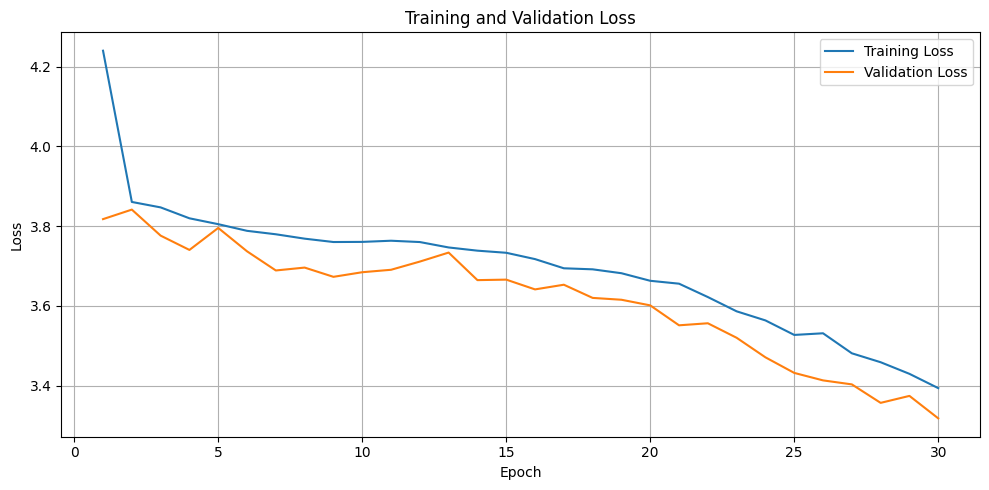

In [18]:
#Plotting train and validation loss
epochs = range(1, len(model.training_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, model.training_losses, label='Training Loss')
plt.plot(epochs, model.validation_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

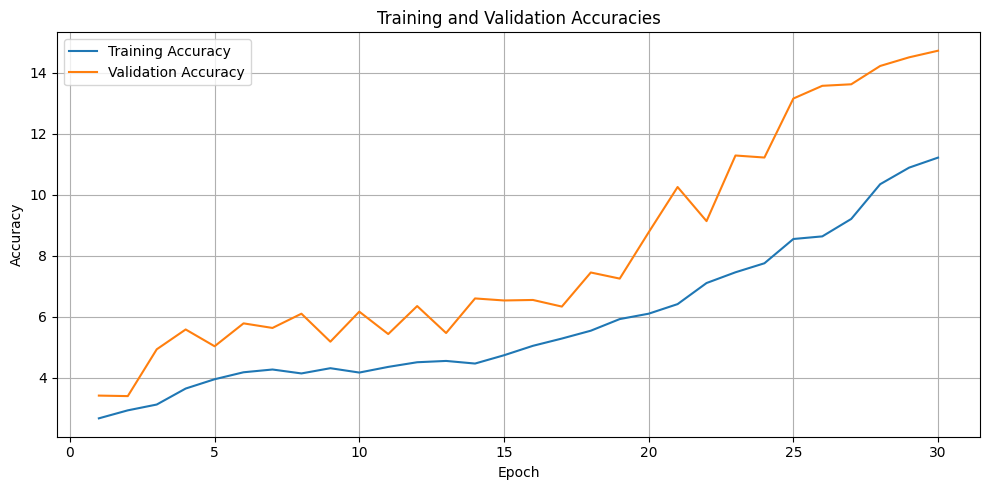

In [19]:
#Plotting train and validation accuracy
epochs = range(1, len(model.training_accuracies) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, [a*100 for a in model.training_accuracies], label='Training Accuracy')
plt.plot(epochs, [a*100 for a in model.validation_accuracies[1:]], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()